# Experiment for Random Feature Residual Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,RidgeCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

df=pd.read_csv('YearPredictionMSD.txt',header=None,sep = ',')
#smaller dataset
train=df.iloc[300000:300700] 
test=df.iloc[500000:500300] 

train_y = train[0]
test_y = test[0] #response:year
train_x = train
test_x = test
del train_x[0]
del test_x[0]
total_x=pd.concat([train_x,test_x])
x=preprocessing.StandardScaler().fit(total_x).transform(total_x) #normalize
x=pd.DataFrame(x)
train_x=x.iloc[:700]
test_x=x.iloc[700:]
train_x ##display the data

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,-1.169588,-0.913331,-1.303357,0.366642,-1.446675,-0.408470,0.866105,0.914454,-1.242843,-0.667838,...,0.207254,0.352000,-1.993373,-0.121706,-0.624721,-3.186580,2.233731,-1.497663,1.015620,1.535324
1,-0.384652,0.083956,-0.409324,0.340569,-0.922879,0.015633,1.158662,0.921513,0.571624,0.059751,...,2.548116,1.116907,-0.863423,-1.574714,1.571018,0.933343,-0.660936,0.018256,-0.441595,0.061384
2,-0.474117,1.071657,-2.011545,1.578102,-0.387551,0.668625,1.009691,-1.046157,0.164916,0.055518,...,-0.107606,-4.416389,6.454818,3.133579,4.412800,-6.273857,-2.294102,6.551096,-0.142954,-0.990494
3,-1.085627,1.033851,-1.001179,2.001694,0.231899,1.523338,1.051318,1.507985,-0.941449,-0.231110,...,0.101883,3.043570,1.424674,-1.320191,1.222839,0.278665,2.211740,0.589111,-2.269302,1.055646
4,-0.705294,-0.778753,-2.057925,-0.842471,0.976928,-0.353554,-0.405709,0.509083,0.569620,-0.519164,...,-1.579429,0.847409,-1.423293,0.122463,-0.858162,-1.384214,0.440914,-1.079154,-0.234252,0.420268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,-1.448799,0.325952,0.582353,0.258919,0.149646,-0.474193,-1.217127,-0.916761,0.088114,-0.320500,...,0.175976,-0.362254,-1.443022,-0.329998,-0.809020,-0.096618,-1.097373,1.158430,-0.030136,-0.139725
696,-0.743319,0.679493,-0.121131,0.266191,0.153593,0.116883,0.285190,0.262373,0.744065,1.012218,...,0.336759,-0.120216,-0.228381,-0.525685,0.470486,-0.179525,-0.485096,-0.265838,-0.166360,-0.097013
697,-1.079830,0.074670,-0.605215,-0.890968,0.940719,-0.745934,-2.093624,-0.008216,1.374812,1.199631,...,0.253918,0.084684,-0.654068,-0.514407,-0.104413,0.146940,-0.811716,0.178947,0.876225,0.210794
698,-0.628019,0.188730,0.035737,-0.332677,0.625774,-0.682705,0.116143,-0.111752,1.780001,0.683753,...,1.043273,0.018961,-0.808076,0.129063,-0.854428,0.051633,0.294883,0.436294,-0.226600,2.013739


## DNN

In [2]:
nntrain_x = torch.from_numpy(train_x.to_numpy()).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float()) 
nntest_x= torch.from_numpy(test_x.to_numpy()).float()
nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len

In [4]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(90, 50)
        self.fc2 = nn.Linear(50, 100)
        self.fc3 = nn.Linear(100, 200)
        self.fc4 = nn.Linear(200, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=0.01,momentum=0.9) #optim.Adam(...)
dnn_trainloss=[]
dnn_testloss=[]
t0=time.time()
for epoch in range(200): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    if epoch % 10 == 0: 
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
    
            test_loss = criterion(y_test_pred,y)
            
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    dnn_trainloss.append(float(train_loss))
    dnn_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("DNN complexity and model fitted in %.3f s" % dnn_fit)

Net(
  (fc1): Linear(in_features=90, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 854697664.0
            Test  set - loss: 947126016.0
            
epoch 10
            Train set - loss: 586297.0
            Test  set - loss: 627590.375
            
epoch 20
            Train set - loss: 504.01226806640625
            Test  set - loss: 650.5567626953125
            
epoch 30
            Train set - loss: 120.4263687133789
            Test  set - loss: 55.904754638671875
            
epoch 40
            Train set - loss: 116.30667877197266
            Test  set - loss: 59.284088134765625
            
epoch 50
            Train set - loss: 129.00421142578125
            Test  set - loss: 58.9889030456543
            
epoch 60
            Train set - loss: 156.3286590576172
          

## Resnet

In [54]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self,features):
        super(ResidualBlock,self).__init__()
        self.features = features
        
        self.fc1 = nn.Linear(features,features)
        self.fc2 = nn.Linear(features,features)
    
    def forward(self, x):
        y= F.relu(self.fc1(x))
        y = self.fc2(y)
        return F.relu(x+y)


class ResNet(nn.Module): 
    def __init__(self):
        super(ResNet, self).__init__()
        self.fc1 = nn.Linear(90,50)
        self.rblock1 = ResidualBlock(50)
        self.fc2 = nn.Linear(50,100)
        self.rblock2 = ResidualBlock(100)
        self.fc3 = nn.Linear(100,200)
        self.rblock3 = ResidualBlock(200)
        self.fc4 = nn.Linear(200,1)
 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.rblock1(x)
        x = F.relu(self.fc2(x))
        x = self.rblock2(x)
        x = F.relu(self.fc3(x))
        x = self.rblock3(x)
        return self.fc4(x)
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9) #optim.Adam(...)
res_trainloss=[]
res_testloss=[]
t0=time.time()
for epoch in range(200): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    if epoch % 10 == 0: 
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
    
            test_loss = criterion(y_test_pred,y)
            
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    res_trainloss.append(float(train_loss))
    res_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("ResNet complexity and model fitted in %.3f s" % dnn_fit)

ResNet(
  (fc1): Linear(in_features=90, out_features=50, bias=True)
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=50, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc2): Linear(in_features=50, out_features=100, bias=True)
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=100, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc3): Linear(in_features=100, out_features=200, bias=True)
  (rblock3): ResidualBlock(
    (fc1): Linear(in_features=200, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=200, bias=True)
  )
  (fc4): Linear(in_features=200, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 104039176.0
            Test  set - loss: 122769528.0
            
epoch 10
            Train set - loss: 25359124.0
            Test  set - loss: 24104442.0
            
epoch 20
            Train set - loss: 610751.1875
           

dropout: self.drop1=nn.Dropout(p=0.5)

## Random Feature

definition of random feature

In [7]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=np.random.randn(1)*gamma
        return w
    elif pdf=='L':
        w=np.random.laplace(1)*gamma
        return w
    elif pdf=='C':
        w=np.random.standard_cauchy(1)*gamma
        return w
    

def sample(pdf, gamma, d):
    return [sample_1d(pdf, gamma) for _ in range(d)]


class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : np.array
        shape (D,d)
    b : np.array
        shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = np.random.uniform(0, 2 * np.pi, self.D)
        self.W = np.reshape(
            np.array([
                sample(self.kernel, self.gamma, self.d)
                for _ in range(self.D)], dtype=np.float32),
            (self.D, self.d))

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : np.array (shape=(n,d))
            Array to transform; must be single dimension vector
        Returns
        -------
        x : np.array (shape=(n,D))
            Feature space transformation of x
        """
        x=pd.DataFrame(x)
        result=np.array([
            np.sqrt(2 / self.D) * np.cos(np.dot(self.W, x.iloc[i]) + self.b) for i in range(len(x))]
            )            
        return result

Linear regression vs single layer random feature model

In [41]:
model =LinearRegression()
model.fit(train_x, train_y)
y_pretest=model.predict(test_x)
y_pretrain=model.predict(train_x)
print("Linear Ridge train mse:",mean_squared_error(train_y,y_pretrain))
print("test mse:",mean_squared_error(test_y,y_pretest))

score=[]
trainmse=[]
testmse=[]
gaset=np.linspace(0.1,0.5,100)
for ga in gaset:
    rff=RandomFourierFeature(90,30,kernel='G',gamma=ga)
    total_x=pd.concat([train_x,test_x])
    feature=rff.transform(total_x)
    train_xtransformed=feature[:len(train_x)]
    test_xtransformed=feature[len(train_x):]
    model.fit(train_xtransformed, train_y)
    y_pretest=model.predict(test_xtransformed)
    y_pretrain=model.predict(train_xtransformed)
    score.append(cross_val_score(model,train_xtransformed,train_y,cv=5).mean())   ##cross-validation
    trainmse.append(mean_squared_error(y_pretrain,train_y))
    testmse.append(mean_squared_error(y_pretest,test_y))
ind=score.index(max(score))
print("cv-score,index,gamma,trainmse,testmse",max(score),ind,gaset[ind],trainmse[ind],testmse[ind])

Linear Ridge train mse: 74.86242454318058
test mse: 154.0442425294812
cv-score,index,gamma,trainmse,testmse -0.838938290207604 4 0.11616161616161616 104.05082633330724 162.40226684422484


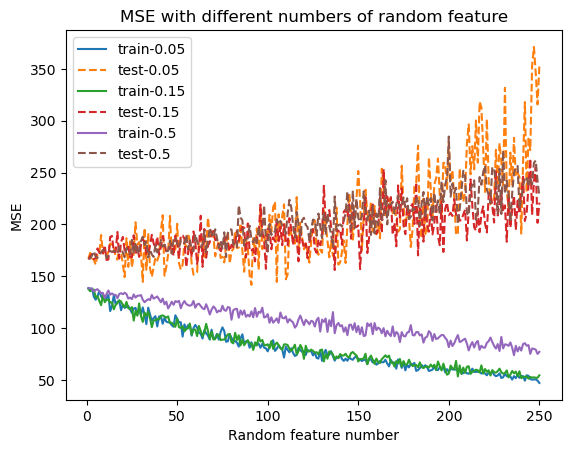

In [43]:
model =LinearRegression() #without bagging
Layer=1
m0set=np.linspace(1,250,250)
m0set=m0set.astype(int)
gaset=[0.05,0.15,0.5]

for ga in gaset:
    trainmse=[]
    testmse=[]
    t=[]
    for m0 in m0set:  
        rff=RandomFourierFeature(90,m0,kernel='G',gamma=ga)
        total_x=pd.concat([train_x,test_x])
        feature=rff.transform(total_x)
        train_xtransformed=feature[:700]
        test_xtransformed=feature[700:]
            
        model.fit(train_xtransformed, train_y)
        y_pretest=model.predict(test_xtransformed)
        y_pretrain=model.predict(train_xtransformed)
        
        trainmse.append(mean_squared_error(train_y,y_pretrain))
        testmse.append(mean_squared_error(test_y,y_pretest))

    plt.plot(m0set,trainmse)
    plt.plot(m0set,testmse,linestyle='dashed')
    

plt.xlabel("Random feature number")
plt.ylabel("MSE")
plt.title("MSE with different numbers of random feature")
plt.legend(["train-0.05","test-0.05","train-0.15","test-0.15","train-0.5","test-0.5"])
plt.show()

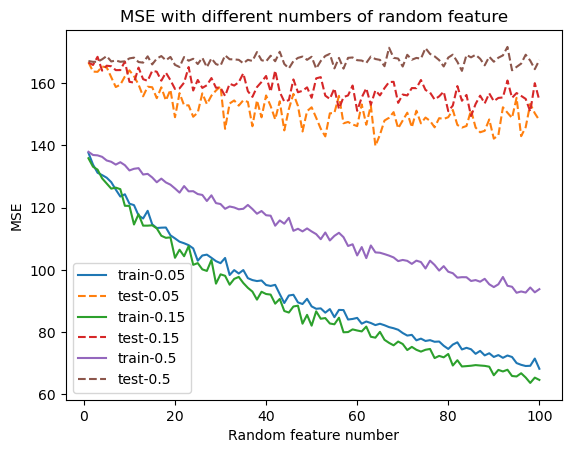

In [44]:
model =LinearRegression() #bagging
Layer=1
m0set=np.linspace(1,100,100)
m0set=m0set.astype(int)
gaset=[0.05,0.15,0.5]
n0=16

for ga in gaset:
    trainmse=[]
    testmse=[]
    t=[]
    for m0 in m0set:  
        for i in range(n0):
            rff=RandomFourierFeature(90,m0,kernel='G',gamma=ga)
            total_x=pd.concat([train_x,test_x])
            feature=rff.transform(total_x)
            train_xtransformed=feature[:700]
            test_xtransformed=feature[700:]
            
            model.fit(train_xtransformed, train_y)
            if i==0:
                y_pretest=model.predict(test_xtransformed)
                y_pretrain=model.predict(train_xtransformed)
            else:
                y_pretest=y_pretest+model.predict(test_xtransformed)
                y_pretrain=y_pretrain+model.predict(train_xtransformed) 
        
        y_pretest=y_pretest/n0
        y_pretrain=y_pretrain/n0
        
        trainmse.append(mean_squared_error(train_y,y_pretrain))
        testmse.append(mean_squared_error(test_y,y_pretest))

    plt.plot(m0set,trainmse)
    plt.plot(m0set,testmse,linestyle='dashed')
    

plt.xlabel("Random feature number")
plt.ylabel("MSE")
plt.title("MSE with different numbers of random feature")
plt.legend(["train-0.05","test-0.05","train-0.15","test-0.15","train-0.5","test-0.5"])
plt.show()

In [ ]:
model =Ridge(alpha=1)
model.fit(train_x, train_y)
y_pretest=model.predict(test_x)
y_pretrain=model.predict(train_x)
print("Linear Ridge train mse:",mean_squared_error(train_y,y_pretrain))
print("test mse:",mean_squared_error(test_y,y_pretest))

score=[]
trainmse=[]
testmse=[]
gaset=np.linspace(0,0.3,100)
for ga in gaset:
    rff=RandomFourierFeature(90,2000,kernel='G',gamma=ga)
    total_x=pd.concat([train_x,test_x])
    feature=rff.transform(total_x)
    train_xtransformed=feature[:len(train_x)]
    test_xtransformed=feature[len(train_x):]
    model.fit(train_xtransformed, train_y)
    y_pretest=model.predict(test_xtransformed)
    y_pretrain=model.predict(train_xtransformed)
    score.append(cross_val_score(model,train_xtransformed,train_y,cv=5).mean())   ##cross-validation
    trainmse.append(mean_squared_error(y_pretrain,train_y))
    testmse.append(mean_squared_error(y_pretest,test_y))
ind=score.index(max(score))
print("cv-score,index,gamma,trainmse,testmse",max(score),ind,gaset[ind],trainmse[ind],testmse[ind])

Linear Ridge train mse: 74.86409656538211
test mse: 153.7107056787628
cv-score,index,gamma,trainmse,testmse -0.4808480141674825 46 0.1393939393939394 46.73350973569064 152.42049196114354


one single gaussian kernel machine

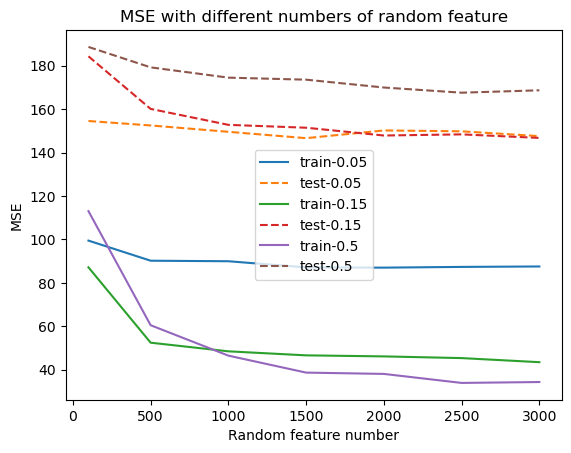

In [12]:
model=Ridge(alpha=1)
Layer=1
m0set=[100,500,1000,1500,2000,2500,3000]
gaset=[0.05,0.15,0.5]

for ga in gaset:
    trainmse=[]
    testmse=[]
    t=[]
    for m0 in m0set:  
        rff=RandomFourierFeature(90,m0,kernel='G',gamma=ga)
        total_x=pd.concat([train_x,test_x])
        feature=rff.transform(total_x)
        train_xtransformed=feature[:700]
        test_xtransformed=feature[700:]
            
        model.fit(train_xtransformed, train_y)
        y_pretest=model.predict(test_xtransformed)
        y_pretrain=model.predict(train_xtransformed)
        
        trainmse.append(mean_squared_error(train_y,y_pretrain))
        testmse.append(mean_squared_error(test_y,y_pretest))

    plt.plot(m0set,trainmse)
    plt.plot(m0set,testmse,linestyle='dashed')
    

plt.xlabel("Random feature number")
plt.ylabel("MSE")
plt.title("MSE with different numbers of random feature")
plt.legend(["train-0.05","test-0.05","train-0.15","test-0.15","train-0.5","test-0.5"])
plt.show()

## multilayer learning

In [62]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)


class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(200, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(10, 1)
        
    def forward(self, x):
        rff=RandomFourierFeature(90,200,kernel='L',gamma=0.01)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x=self.fc1(x)
        rff=RandomFourierFeature(50,50,kernel='C',gamma=0.1)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x=self.fc2(x)
        rff=RandomFourierFeature(10,10,kernel='G',gamma=1)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=0.01,momentum=0.9) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(200): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    if epoch % 10 == 0: 
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
    
            test_loss = criterion(y_test_pred,y)
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    kernelnn_trainloss.append(float(train_loss))
    kernelnn_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=200, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 1886903.875
            Test  set - loss: 1664267.25
            
epoch 10
            Train set - loss: 4943.6298828125
            Test  set - loss: 6385.90185546875
            
epoch 20
            Train set - loss: 374.8407897949219
            Test  set - loss: 448.5638427734375
            
epoch 30
            Train set - loss: 168.1480255126953
            Test  set - loss: 56.48063659667969
            
epoch 40
            Train set - loss: 135.9540557861328
            Test  set - loss: 59.17245101928711
            
epoch 50
            Train set - loss: 135.30711364746094
            Test  set - loss: 61.0399284362793
            
epoch 60
            Train set - loss: 132.19961547851562
            Test  set - loss: 61.166446685791016
         

## Residual multilayer learning

In [56]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self,features):
        super(ResidualBlock,self).__init__()
        self.features = features
        
        self.fc1 = nn.Linear(features,features)
        self.fc2 = nn.Linear(features,features)
    
    def forward(self, x):
        y = F.relu(self.fc1(x))
        y = self.fc2(y)
        return F.relu(x+y)

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(50)
        self.fc1 = nn.Linear(50, 50)
        self.rblock2 = ResidualBlock(100)
        self.fc2 = nn.Linear(100, 50)
        self.rblock3 = ResidualBlock(200)
        self.fc3 = nn.Linear(200, 1)
 
    def forward(self, x):
        rff=RandomFourierFeature(90,50,kernel='G',gamma=1)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x = self.rblock1(x)
        x = self.fc1(x)
        rff=RandomFourierFeature(50,100,kernel='C',gamma=0.1)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x = self.rblock2(x)
        x = self.fc2(x)
        rff=RandomFourierFeature(50,200,kernel='L',gamma=0.01)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x = self.rblock3(x)
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9) #optim.Adam(...)

loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(200): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    if epoch % 10 == 0: 
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
    
            test_loss = criterion(y_test_pred,y)
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    reskernel_trainloss.append(float(train_loss))
    reskernel_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=50, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=100, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (rblock3): ResidualBlock(
    (fc1): Linear(in_features=200, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=200, bias=True)
  )
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 4146762.0
            Test  set - loss: 4143811.25
            
epoch 10
            Train set - loss: 209410.125
            Test  set - loss: 204022.3125
            
epoch 20
            Train set - loss: 4993.43896484375
            Test  set - loss: 5387.396484375
            
epoch 

DNN vs multilayer kernel

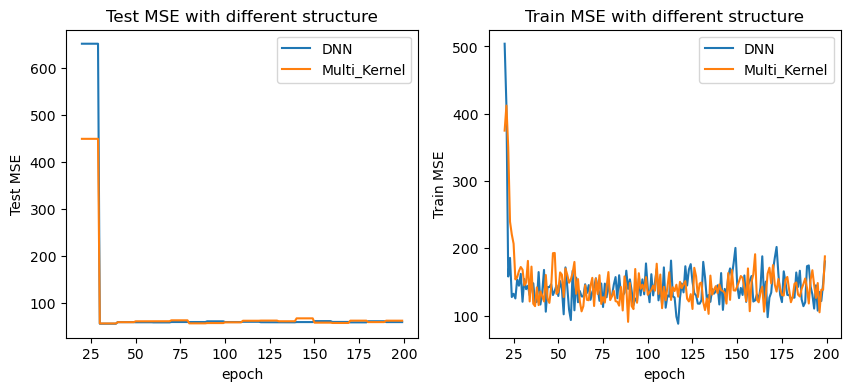

In [63]:
a=np.linspace(20,199,180)
epochset = [int(item) for item in a]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(epochset,dnn_testloss[20:])
ax[0].plot(epochset,kernelnn_testloss[20:])
ax[0].legend(["DNN","Multi_Kernel"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Test MSE")
ax[0].set_title("Test MSE with different structure")

ax[1].plot(epochset,dnn_trainloss[20:])
ax[1].plot(epochset,kernelnn_trainloss[20:])
ax[1].legend(["DNN","Multi_Kernel"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Train MSE")
ax[1].set_title("Train MSE with different structure")
plt.show()

Resnet vs multilayer residual kernel

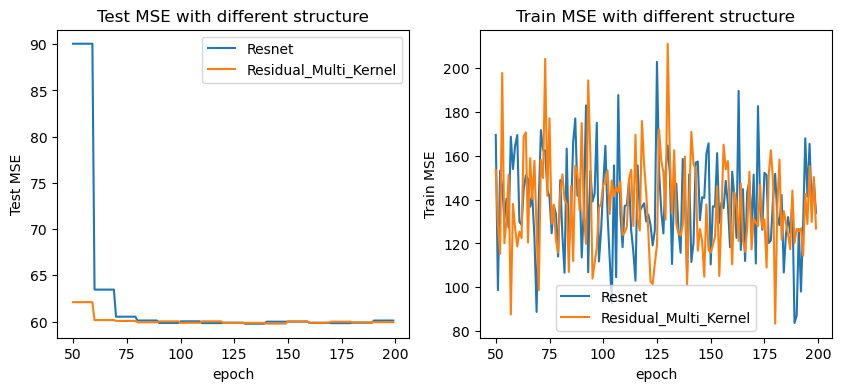

In [59]:
a=np.linspace(50,199,150)
epochset = [int(item) for item in a]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(epochset,res_testloss[50:])
ax[0].plot(epochset,reskernel_testloss[50:])
ax[0].legend(["Resnet","Residual_Multi_Kernel"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Test MSE")
ax[0].set_title("Test MSE with different structure")

ax[1].plot(epochset,res_trainloss[50:])
ax[1].plot(epochset,reskernel_trainloss[50:])
ax[1].legend(["Resnet","Residual_Multi_Kernel"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Train MSE")
ax[1].set_title("Train MSE with different structure")
plt.show()

## data splitting for one time

In [11]:
#improve shuffle+L2 regularization
split=1
layer=3
length=int(len(train_x)/(2**layer-1))
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self,features):
        super(ResidualBlock,self).__init__()
        self.features = features
        
        self.fc1 = nn.Linear(features,features)
        self.fc2 = nn.Linear(features,features)
    
    def forward(self, x):
        y = F.relu(self.fc1(x))
        y = self.fc2(y)
        return F.relu(x+y)

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(50)
        self.fc1 = nn.Linear(50, 50)
        self.rblock2 = ResidualBlock(100)
        self.fc2 = nn.Linear(100, 50)
        self.rblock3 = ResidualBlock(200)
        self.fc3 = nn.Linear(200, 1)
 
    def forward(self, x):
        rff=RandomFourierFeature(90,50,kernel='G',gamma=1)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x = self.rblock1(x)
        x = self.fc1(x)
        rff=RandomFourierFeature(50,100,kernel='G',gamma=0.1)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x = self.rblock2(x)
        x = self.fc2(x)
        rff=RandomFourierFeature(50,200,kernel='C',gamma=0.01)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x = self.rblock3(x)
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

for i in range(split): #the case of split=1
    row_rand_array = np.arange(train_x.shape[0])
    np.random.shuffle(row_rand_array)
    train_loaderset=[]
    
    for l in range(layer): #split into different dataset
        curx=pd.DataFrame(train_x.values[row_rand_array[(2**l-1)*length:(2**(l+1)-1)*length]])
        cury=pd.DataFrame(train_y.values[row_rand_array[(2**l-1)*length:(2**(l+1)-1)*length]])
        nnx = torch.from_numpy(curx.to_numpy()).float()
        nny = torch.squeeze(torch.from_numpy(cury.to_numpy()).float()) 
        train_loader = DataLoader(mydataset(nnx, nny),batch_size=100, shuffle=True)
        train_loaderset.append(train_loader)
        
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResKernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    print(net)
    criterion=nn.MSELoss() 
    optimizer=[]
    
    weight_fc1 = [param for name, param in net.fc1.named_parameters() if "bias" not in name]
    bias_fc1 = [param for name, param in net.fc1.named_parameters() if "bias" in name]
    weight_r1 = [param for name, param in net.rblock1.named_parameters() if "bias" not in name]
    bias_r1 = [param for name, param in net.rblock1.named_parameters() if "bias" in name]
    
    weight_fc2 = [param for name, param in net.fc2.named_parameters() if "bias" not in name]
    bias_fc2 = [param for name, param in net.fc2.named_parameters() if "bias" in name]
    weight_r2 = [param for name, param in net.rblock2.named_parameters() if "bias" not in name]
    bias_r2 = [param for name, param in net.rblock2.named_parameters() if "bias" in name]
    
    weight_fc3 = [param for name, param in net.fc3.named_parameters() if "bias" not in name]
    bias_fc3 = [param for name, param in net.fc3.named_parameters() if "bias" in name]
    weight_r3 = [param for name, param in net.rblock3.named_parameters() if "bias" not in name]
    bias_r3 = [param for name, param in net.rblock3.named_parameters() if "bias" in name]

    #optim_wdecay = optim.SGD(net_weight_decay.parameters(), lr=lr_init, momentum=0.9, weight_decay=1e-2)
    optimizer.append(optim.SGD([{'params': weight_fc1, 'weight_decay':1e-5},
                               {'params': bias_fc1, 'weight_decay':0},
                               {'params': weight_r1, 'weight_decay':1e-5},
                               {'params': bias_r1, 'weight_decay':0}],lr=0.1,momentum=0.9) )
    optimizer.append(optim.SGD([{'params': weight_fc2, 'weight_decay':1e-5},
                               {'params': bias_fc2, 'weight_decay':0},
                               {'params': weight_r2, 'weight_decay':1e-5},
                               {'params': bias_r2, 'weight_decay':0}],lr=0.01,momentum=0.9) )
    optimizer.append(optim.SGD([{'params': weight_fc3, 'weight_decay':1e-5},
                               {'params': bias_fc3, 'weight_decay':0},
                               {'params': weight_r3, 'weight_decay':1e-5},
                               {'params': bias_r3, 'weight_decay':0}],lr=0.001,momentum=0.9) )
    loss=[]
    splreskernel_trainloss=[]
    splreskernel_testloss=[]
    t0 = time.time()
    for epoch in range(200): 
        for l in range(layer):
            for x, y in train_loaderset[l]: #for batch, (x, y) in enumerate(train_loader): 
                # Data Splitting
                # every step, update a layer with smaller dataset 
                x, y = x.to(device), y.to(device)
                # Compute prediction error
                y_pred = net(x)
                y_pred = torch.squeeze(y_pred)
                train_loss = criterion(y_pred, y)
                loss.append(train_loss)
                # Backpropagation
                optimizer[l].zero_grad() 
                train_loss.backward()
                optimizer[l].step()
            
        if epoch % 10 == 0: 
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                y_test_pred = net(x)
                y_test_pred = torch.squeeze(y_test_pred)
        
                test_loss = criterion(y_test_pred,y)
            print(f'''epoch {epoch}
                Train set - loss: {train_loss}
                Test  set - loss: {test_loss}
                ''')
        splreskernel_trainloss.append(float(train_loss))
        splreskernel_testloss.append(float(test_loss))
            
        
    dnn_fit = time.time() - t0
    print("Residual KernelNet(data splitting) complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=50, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=100, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (rblock3): ResidualBlock(
    (fc1): Linear(in_features=200, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=200, bias=True)
  )
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
epoch 0
                Train set - loss: 114262592.0
                Test  set - loss: 3959427.75
                
epoch 10
                Train set - loss: 3717399.75
                Test  set - loss: 3592839.75
                
epoch 20
                Train set - loss: 548998.75
                Test  set - loss: 528918.2

In [50]:
#+dropout+prune
split=1
layer=3
length=int(len(train_x)/layer)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self,features):
        super(ResidualBlock,self).__init__()
        self.features = features
        
        self.fc1 = nn.Linear(features,features)
        self.fc2 = nn.Linear(features,features)
    
    def forward(self, x):
        y = F.relu(self.fc1(x))
        y = self.fc2(y)
        return F.relu(x+y)

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(50)
        self.rdrop1=nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(50, 50)
        self.ldrop1=nn.Dropout(p=0.5)
        self.rblock2 = ResidualBlock(100)
        self.rdrop2=nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(100, 50)
        self.ldrop2=nn.Dropout(p=0.5)
        self.rblock3 = ResidualBlock(200)
        self.rdrop3=nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(200, 1)
 
    def forward(self, x):
        rff=RandomFourierFeature(90,50,kernel='G',gamma=1)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x = self.rblock1(x)
        x = self.rdrop1(x)
        x = self.fc1(x)
        x = self.ldrop1(x)
        rff=RandomFourierFeature(50,100,kernel='C',gamma=0.1)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x = self.rblock2(x)
        x = self.rdrop2(x)
        x = self.fc2(x)
        x = self.rdrop2(x)
        rff=RandomFourierFeature(50,200,kernel='L',gamma=0.01)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x = self.rblock3(x)
        x = self.rdrop3(x)
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

for i in range(split): #the case of split=1
    row_rand_array = np.arange(train_x.shape[0])
    np.random.shuffle(row_rand_array)
    train_loaderset=[]
    
    for l in range(layer): #split into different dataset
        curx=pd.DataFrame(train_x.values[row_rand_array[l*length:(l+1)*length]])
        cury=pd.DataFrame(train_y.values[row_rand_array[l*length:(l+1)*length]])
        nnx = torch.from_numpy(curx.to_numpy()).float()
        nny = torch.squeeze(torch.from_numpy(cury.to_numpy()).float()) 
        train_loader = DataLoader(mydataset(nnx, nny),batch_size=100, shuffle=True)
        train_loaderset.append(train_loader)
        
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResKernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    print(net)
    criterion=nn.MSELoss() 
    optimizer=[]
    optimizer.append(optim.SGD([{'params': net.fc1.parameters()},
                               {'params': net.rblock1.parameters()}],lr=0.01,momentum=0.9) )
    optimizer.append(optim.SGD([{'params': net.fc2.parameters()},
                               {'params': net.rblock2.parameters()}],lr=0.01,momentum=0.9) )
    optimizer.append(optim.SGD([{'params': net.fc3.parameters()},
                               {'params': net.rblock3.parameters()}],lr=0.001,momentum=0.9) )
    loss=[]
    splreskernel_trainloss=[]
    splreskernel_testloss=[]
    t0 = time.time()
    for epoch in range(200): 
        for l in range(layer):
            for x, y in train_loaderset[l]: #for batch, (x, y) in enumerate(train_loader): 
                # Data Splitting
                # every step, update a layer with smaller dataset 
                x, y = x.to(device), y.to(device)
                # Compute prediction error
                y_pred = net(x)
                y_pred = torch.squeeze(y_pred)
                train_loss = criterion(y_pred, y)
                loss.append(train_loss)
                # Backpropagation
                optimizer[l].zero_grad() 
                train_loss.backward()
                optimizer[l].step()
            
        if epoch % 10 == 0: 
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                y_test_pred = net(x)
                y_test_pred = torch.squeeze(y_test_pred)
        
                test_loss = criterion(y_test_pred,y)
            print(f'''epoch {epoch}
                Train set - loss: {train_loss}
                Test  set - loss: {test_loss}
                ''')
        splreskernel_trainloss.append(float(train_loss))
        splreskernel_testloss.append(float(test_loss))
            
        
    dnn_fit = time.time() - t0
    print("Residual KernelNet(data splitting) complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=50, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=50, bias=True)
  )
  (rdrop1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (ldrop1): Dropout(p=0.5, inplace=False)
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=100, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
  )
  (rdrop2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (ldrop2): Dropout(p=0.5, inplace=False)
  (rblock3): ResidualBlock(
    (fc1): Linear(in_features=200, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=200, bias=True)
  )
  (rdrop3): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
epoch 0
                Train set - loss: 3944022.25
                Test  set - loss: 3918510.0
                
epo

In [51]:
parameters_to_prune = (
    (net.fc1, 'weight'),
    (net.rblock1.fc1, 'weight'),
    (net.rblock1.fc2, 'weight'),
    (net.fc2, 'weight'),
    (net.rblock2.fc1, 'weight'),
    (net.rblock2.fc2, 'weight'),
    (net.fc3, 'weight'),
    (net.rblock3.fc1, 'weight'),
    (net.rblock3.fc2, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

print(
    "Sparsity in net.fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(net.fc1.weight == 0))
        / float(net.fc1.weight.nelement())
    )
)
print(
    "Sparsity in net.fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(net.fc2.weight == 0))
        / float(net.fc2.weight.nelement())
    )
)
print(
    "Sparsity in net.fc3.weight: {:.2f}%".format(
        100. * float(torch.sum(net.fc3.weight == 0))
        / float(net.fc3.weight.nelement())
    )
)

print(
    "Sparsity in net.rblock1.fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(net.rblock1.fc1.weight == 0))
        / float(net.fc1.weight.nelement())
    )
)
print(
    "Sparsity in net.rblock1.fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(net.rblock1.fc2.weight == 0))
        / float(net.fc2.weight.nelement())
    )
)
print(
    "Sparsity in net.rblock2.fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(net.rblock1.fc1.weight == 0))
        / float(net.fc1.weight.nelement())
    )
)
print(
    "Sparsity in net.rblock2.fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(net.rblock1.fc2.weight == 0))
        / float(net.fc2.weight.nelement())
    )
)
print(
    "Sparsity in net.rblock3.fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(net.rblock1.fc1.weight == 0))
        / float(net.fc1.weight.nelement())
    )
)
print(
    "Sparsity in net.rblock3.fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(net.rblock1.fc2.weight == 0))
        / float(net.fc2.weight.nelement())
    )
)

prune.remove(net.fc1, 'weight')
prune.remove(net.rblock1.fc1, 'weight')
prune.remove(net.rblock1.fc2, 'weight')
prune.remove(net.fc2, 'weight')
prune.remove(net.rblock2.fc1, 'weight')
prune.remove(net.rblock2.fc2, 'weight')
prune.remove(net.fc3, 'weight')
prune.remove(net.rblock3.fc1, 'weight')
prune.remove(net.rblock3.fc2, 'weight')
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    y_test_pred = net(x)
    y_test_pred = torch.squeeze(y_test_pred)
        
    test_loss = criterion(y_test_pred,y)
print(f'''epoch {epoch}
        Train set - loss: {train_loss}
        Test  set - loss: {test_loss}
        ''')

Sparsity in net.fc1.weight: 50.36%
Sparsity in net.fc2.weight: 51.62%
Sparsity in net.fc3.weight: 0.00%
Sparsity in net.rblock1.fc1.weight: 52.24%
Sparsity in net.rblock1.fc2.weight: 26.50%
Sparsity in net.rblock2.fc1.weight: 52.24%
Sparsity in net.rblock2.fc2.weight: 26.50%
Sparsity in net.rblock3.fc1.weight: 52.24%
Sparsity in net.rblock3.fc2.weight: 26.50%
epoch 199
        Train set - loss: 277.8416748046875
        Test  set - loss: 58.17534255981445
        


In [81]:
#improve shuffle+dropout+prune
split=1
layer=3
length=int(len(train_x)/(2**layer-1))
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self,features):
        super(ResidualBlock,self).__init__()
        self.features = features
        
        self.fc1 = nn.Linear(features,features)
        self.fc2 = nn.Linear(features,features)
    
    def forward(self, x):
        y = F.relu(self.fc1(x))
        y = self.fc2(y)
        return F.relu(x+y)

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(50)
        self.rdrop1=nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(50, 50)
        self.ldrop1=nn.Dropout(p=0.5)
        self.rblock2 = ResidualBlock(100)
        self.rdrop2=nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(100, 50)
        self.ldrop2=nn.Dropout(p=0.5)
        self.rblock3 = ResidualBlock(200)
        self.rdrop3=nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(200, 1)
 
    def forward(self, x):
        rff=RandomFourierFeature(90,50,kernel='G',gamma=1)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x = self.rblock1(x)
        x = self.rdrop1(x)
        x = self.fc1(x)
        x = self.ldrop1(x)
        rff=RandomFourierFeature(50,100,kernel='C',gamma=0.1)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x = self.rblock2(x)
        x = self.rdrop2(x)
        x = self.fc2(x)
        x = self.rdrop2(x)
        rff=RandomFourierFeature(50,200,kernel='L',gamma=0.01)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x = self.rblock3(x)
        x = self.rdrop3(x)
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

for i in range(split): #the case of split=1
    row_rand_array = np.arange(train_x.shape[0])
    np.random.shuffle(row_rand_array)
    train_loaderset=[]
    
    for l in range(layer): #split into different dataset
        curx=pd.DataFrame(train_x.values[row_rand_array[(2**l-1)*length:(2**(l+1)-1)*length]])
        cury=pd.DataFrame(train_y.values[row_rand_array[(2**l-1)*length:(2**(l+1)-1)*length]])
        nnx = torch.from_numpy(curx.to_numpy()).float()
        nny = torch.squeeze(torch.from_numpy(cury.to_numpy()).float()) 
        train_loader = DataLoader(mydataset(nnx, nny),batch_size=100, shuffle=True)
        train_loaderset.append(train_loader)
        
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResKernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    print(net)
    criterion=nn.MSELoss() 
    optimizer=[]
    optimizer.append(optim.SGD([{'params': net.fc1.parameters()},
                               {'params': net.rblock1.parameters()}],lr=0.1,momentum=0.9) )
    optimizer.append(optim.SGD([{'params': net.fc2.parameters()},
                               {'params': net.rblock2.parameters()}],lr=0.01,momentum=0.9) )
    optimizer.append(optim.SGD([{'params': net.fc3.parameters()},
                               {'params': net.rblock3.parameters()}],lr=0.001,momentum=0.9) )
    loss=[]
    onesplreskernel_trainloss=[]
    onesplreskernel_testloss=[]
    t0 = time.time()
    for epoch in range(200): 
        for l in range(layer):
            for x, y in train_loaderset[l]: #for batch, (x, y) in enumerate(train_loader): 
                # Data Splitting
                # every step, update a layer with smaller dataset 
                x, y = x.to(device), y.to(device)
                # Compute prediction error
                y_pred = net(x)
                y_pred = torch.squeeze(y_pred)
                train_loss = criterion(y_pred, y)
                loss.append(train_loss)
                # Backpropagation
                optimizer[l].zero_grad() 
                train_loss.backward()
                optimizer[l].step()
            
        if epoch % 10 == 0: 
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                y_test_pred = net(x)
                y_test_pred = torch.squeeze(y_test_pred)
        
                test_loss = criterion(y_test_pred,y)
            print(f'''epoch {epoch}
                Train set - loss: {train_loss}
                Test  set - loss: {test_loss}
                ''')
        onesplreskernel_trainloss.append(float(train_loss))
        onesplreskernel_testloss.append(float(test_loss))
            
        
    dnn_fit = time.time() - t0
    print("Residual KernelNet(data splitting) complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=50, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=50, bias=True)
  )
  (rdrop1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (ldrop1): Dropout(p=0.5, inplace=False)
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=100, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
  )
  (rdrop2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (ldrop2): Dropout(p=0.5, inplace=False)
  (rblock3): ResidualBlock(
    (fc1): Linear(in_features=200, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=200, bias=True)
  )
  (rdrop3): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
epoch 0
                Train set - loss: 3966947.25
                Test  set - loss: 3944178.5
                
epo

In [82]:
parameters_to_prune = (
    (net.fc1, 'weight'),
    (net.rblock1.fc1, 'weight'),
    (net.rblock1.fc2, 'weight'),
    (net.fc2, 'weight'),
    (net.rblock2.fc1, 'weight'),
    (net.rblock2.fc2, 'weight'),
    (net.fc3, 'weight'),
    (net.rblock3.fc1, 'weight'),
    (net.rblock3.fc2, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

print(
    "Sparsity in net.fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(net.fc1.weight == 0))
        / float(net.fc1.weight.nelement())
    )
)
print(
    "Sparsity in net.fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(net.fc2.weight == 0))
        / float(net.fc2.weight.nelement())
    )
)
print(
    "Sparsity in net.fc3.weight: {:.2f}%".format(
        100. * float(torch.sum(net.fc3.weight == 0))
        / float(net.fc3.weight.nelement())
    )
)

print(
    "Sparsity in net.rblock1.fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(net.rblock1.fc1.weight == 0))
        / float(net.fc1.weight.nelement())
    )
)
print(
    "Sparsity in net.rblock1.fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(net.rblock1.fc2.weight == 0))
        / float(net.fc2.weight.nelement())
    )
)
print(
    "Sparsity in net.rblock2.fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(net.rblock1.fc1.weight == 0))
        / float(net.fc1.weight.nelement())
    )
)
print(
    "Sparsity in net.rblock2.fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(net.rblock1.fc2.weight == 0))
        / float(net.fc2.weight.nelement())
    )
)
print(
    "Sparsity in net.rblock3.fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(net.rblock1.fc1.weight == 0))
        / float(net.fc1.weight.nelement())
    )
)
print(
    "Sparsity in net.rblock3.fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(net.rblock1.fc2.weight == 0))
        / float(net.fc2.weight.nelement())
    )
)

prune.remove(net.fc1, 'weight')
prune.remove(net.rblock1.fc1, 'weight')
prune.remove(net.rblock1.fc2, 'weight')
prune.remove(net.fc2, 'weight')
prune.remove(net.rblock2.fc1, 'weight')
prune.remove(net.rblock2.fc2, 'weight')
prune.remove(net.fc3, 'weight')
prune.remove(net.rblock3.fc1, 'weight')
prune.remove(net.rblock3.fc2, 'weight')
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    y_test_pred = net(x)
    y_test_pred = torch.squeeze(y_test_pred)
        
    test_loss = criterion(y_test_pred,y)
print(f'''epoch {epoch}
        Train set - loss: {train_loss}
        Test  set - loss: {test_loss}
        ''')

Sparsity in net.fc1.weight: 62.08%
Sparsity in net.fc2.weight: 63.52%
Sparsity in net.fc3.weight: 0.00%
Sparsity in net.rblock1.fc1.weight: 64.28%
Sparsity in net.rblock1.fc2.weight: 32.62%
Sparsity in net.rblock2.fc1.weight: 64.28%
Sparsity in net.rblock2.fc2.weight: 32.62%
Sparsity in net.rblock3.fc1.weight: 64.28%
Sparsity in net.rblock3.fc2.weight: 32.62%
epoch 199
        Train set - loss: 155.5817413330078
        Test  set - loss: 54.702510833740234
        


## data splitting with repeating

In [ ]:
split=16
layer=3
length=int(len(train_x)/(2**layer-1))
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self,features):
        super(ResidualBlock,self).__init__()
        self.features = features
        
        self.fc1 = nn.Linear(features,features)
        self.fc2 = nn.Linear(features,features)
    
    def forward(self, x):
        y = F.relu(self.fc1(x))
        y = self.fc2(y)
        return F.relu(x+y)

class ResidualBlock(nn.Module):
    def __init__(self,features):
        super(ResidualBlock,self).__init__()
        self.features = features
        
        self.fc1 = nn.Linear(features,features)
        self.fc2 = nn.Linear(features,features)
    
    def forward(self, x):
        y = F.relu(self.fc1(x))
        y = self.fc2(y)
        return F.relu(x+y)

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(50)
        self.fc1 = nn.Linear(50, 50)
        self.rblock2 = ResidualBlock(100)
        self.fc2 = nn.Linear(100, 50)
        self.rblock3 = ResidualBlock(200)
        self.fc3 = nn.Linear(200, 1)
 
    def forward(self, x):
        rff=RandomFourierFeature(90,50,kernel='G',gamma=1)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x = self.rblock1(x)
        x = self.fc1(x)
        rff=RandomFourierFeature(50,100,kernel='G',gamma=0.1)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x = self.rblock2(x)
        x = self.fc2(x)
        rff=RandomFourierFeature(50,200,kernel='C',gamma=0.01)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x = self.rblock3(x)
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

train_loaderset=[] # there are "split" elements
netset=[]
optimizerset=[]
train_loss=[]
test_loss=[]
for i in range(split):
    row_rand_array = np.arange(train_x.shape[0])
    np.random.shuffle(row_rand_array)
    train_loaderset1=[] # there are "layer" elements
    
    for l in range(layer): # split into different dataset
        curx=pd.DataFrame(train_x.values[row_rand_array[(2**l-1)*length:(2**(l+1)-1)*length]])
        cury=pd.DataFrame(train_y.values[row_rand_array[(2**l-1)*length:(2**(l+1)-1)*length]])
        nnx = torch.from_numpy(curx.to_numpy()).float()
        nny = torch.squeeze(torch.from_numpy(cury.to_numpy()).float()) 
        train_loader = DataLoader(mydataset(nnx, nny),batch_size=100, shuffle=True)
        train_loaderset1.append(train_loader)
    train_loaderset.append(train_loaderset1)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResKernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    netset.append(net)      
   
    optimizer1=[]
    optimizer1.append(optim.SGD([{'params': net.fc1.parameters()},
                               {'params': net.rblock1.parameters()}],lr=0.1,momentum=0.9) )
    optimizer1.append(optim.SGD([{'params': net.fc2.parameters()},
                               {'params': net.rblock2.parameters()}],lr=0.01,momentum=0.9) )
    optimizer1.append(optim.SGD([{'params': net.fc3.parameters()},
                               {'params': net.rblock3.parameters()}],lr=0.001,momentum=0.9) )
    optimizerset.append(optimizer1)
    
    train_loss.append(0)
    test_loss.append(0)
    
criterion=nn.MSELoss()    
loss=[]
splreskernel_trainloss=[]
splreskernel_testloss=[]

t0 = time.time()


for epoch in range(200): 
    for i in range(split):
    
        for l in range(layer):
            for x, y in train_loaderset[i][l]: #for batch, (x, y) in enumerate(train_loader): 
                # Data Splitting
                # every step, update a layer with smaller dataset 
                x, y = x.to(device), y.to(device)
                # Compute prediction error
                y_pred = netset[i](x)
                y_pred = torch.squeeze(y_pred)
                train_loss[i] = criterion(y_pred, y)
                
                # Backpropagation
                optimizerset[i][l].zero_grad() 
                train_loss[i].backward()
                optimizerset[i][l].step()
            
    if epoch % 10 == 0: 
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            for i in range(split):
                y_test_pred = netset[i](x)
                y_test_pred = torch.squeeze(y_test_pred)
            
                test_loss[i] = criterion(y_test_pred,y)
        print(f'''epoch {epoch}
            Train set - loss: {sum(train_loss)/len(train_loss)}
            Test  set - loss: {sum(test_loss)/len(test_loss)}
            ''')
    splreskernel_trainloss.append(float(sum(train_loss)/len(train_loss)))
    splreskernel_testloss.append(float(sum(test_loss)/len(test_loss)))
            
        
dnn_fit = time.time() - t0
print("Residual KernelNet(data splitting) complexity and model fitted in %.3f s" % dnn_fit)

epoch 0
            Train set - loss: 3946262.25
            Test  set - loss: 3922617.25
            
epoch 10
            Train set - loss: 875096.0625
            Test  set - loss: 840393.0
            
epoch 20
            Train set - loss: 109159.265625
            Test  set - loss: 106528.40625
            
epoch 30
            Train set - loss: 12984.7705078125
            Test  set - loss: 13209.599609375
            
epoch 40
            Train set - loss: 1664.0479736328125
            Test  set - loss: 1807.774658203125
            
epoch 50
            Train set - loss: 313.10382080078125
            Test  set - loss: 336.15887451171875
            
epoch 60
            Train set - loss: 156.95370483398438
            Test  set - loss: 117.05059051513672
            
epoch 70
            Train set - loss: 145.3054656982422
            Test  set - loss: 75.27342987060547
            
epoch 80
            Train set - loss: 140.1796875
            Test  set - loss: 64.854385375

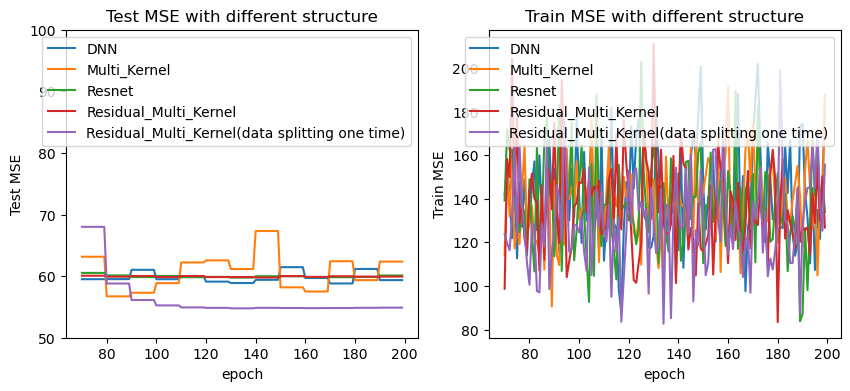

In [83]:
a=np.linspace(70,199,130)
epochset = [int(item) for item in a]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(epochset,dnn_testloss[70:])
ax[0].plot(epochset,kernelnn_testloss[70:])
ax[0].plot(epochset,res_testloss[70:])
ax[0].plot(epochset,reskernel_testloss[70:])
ax[0].plot(epochset,onesplreskernel_testloss[70:])
ax[0].legend(["DNN","Multi_Kernel","Resnet","Residual_Multi_Kernel","Residual_Multi_Kernel(data splitting one time)"])
ax[0].set_ylim([50,100])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Test MSE")
ax[0].set_title("Test MSE with different structure")

ax[1].plot(epochset,dnn_trainloss[70:])
ax[1].plot(epochset,kernelnn_trainloss[70:])
ax[1].plot(epochset,res_trainloss[70:])
ax[1].plot(epochset,reskernel_trainloss[70:])
ax[1].plot(epochset,onesplreskernel_trainloss[70:])
ax[1].legend(["DNN","Multi_Kernel","Resnet","Residual_Multi_Kernel","Residual_Multi_Kernel(data splitting one time)"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Train MSE")
ax[1].set_title("Train MSE with different structure")
plt.show()

## residual learning

several parts with rotation

random shuffle: average

random shuffle n/2